## Predict the color based on name

* Enter some text and the model outputs a color block predicting the color
* Trained on color names and their RGB values

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv 
import matplotlib.pyplot as plt
import numpy as np
import os

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  323k  100  323k    0     0   909k      0 --:--:-- --:--:-- --:--:--  907k
name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [3]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [4]:
names = [item[0] for item in colors_rgb]

In [5]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = pad_sequences(tokenized, maxlen=maxlen)
padded_names = padded_names.astype('float32')

In [6]:
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
# FIX ME
model.add(tf.keras.layers.GRU(128, return_sequences=True))
model.add(tf.keras.layers.GRU(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse') # NO SOFTMAX since we want the predicted value not probs!!
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 25)             0         
_________________________________________________________________
gru (GRU)                    (None, 1, 128)            59136     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 166,275
Trainable params: 166,275
Non-trainable params: 0
_________________________________________________________________


In [9]:
# we're going to massively overfit on the training
# data... that's fine for this experiment
history = model.fit(padded_names, targets, epochs=5, validation_split=0.1)

Epoch 1/5
399/399 [==============================] - 9s 21ms/step - loss: 0.0630 - val_loss: 0.0632
Epoch 2/5
399/399 [==============================] - 9s 21ms/step - loss: 0.0594 - val_loss: 0.0635
Epoch 3/5
399/399 [==============================] - 9s 21ms/step - loss: 0.0575 - val_loss: 0.0613
Epoch 4/5
399/399 [==============================] - 8s 21ms/step - loss: 0.0559 - val_loss: 0.0603
Epoch 5/5
399/399 [==============================] - 8s 21ms/step - loss: 0.0545 - val_loss: 0.0618


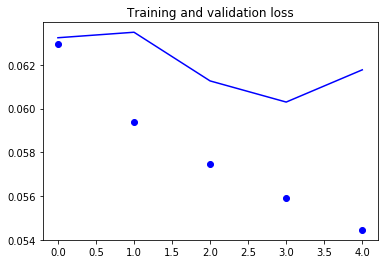

In [10]:
# let's see how badly we've overfit
# (don't worry about it for this assignment)
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

In [11]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [12]:
def scale(n):
    return int(n * 255)

In [26]:
def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    # Check the shapes here if you run into trouble with the next 
    # method after adding your RNN
    print(pred)
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

[0.4922469 0.6660514 0.7520429]
light blue, R,G,B: 125 169 191


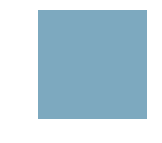

[0.44553363 0.531113   0.6146486 ]
blue, R,G,B: 113 135 156


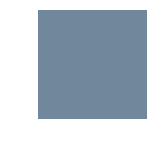

[0.7328921  0.49961418 0.38153782]
orange, R,G,B: 186 127 97


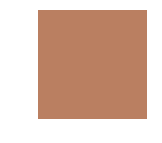

In [27]:
# some "test" data
predict("light blue")
predict("blue")
predict("orange")